In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
%matplotlib inline

Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [49]:
tickers = dict(
    SPY=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond')
)

In [268]:
pd.DataFrame.from_dict(tickers, orient='index')

,asset,vol
AGG,bond,0.003143
EFA,equity,0.014107
EMB,bond,0.007078
HYG,bond,0.008003
IJH,equity,0.013328
IJR,equity,0.014284
IWF,equity,0.012712
LQD,bond,0.005037
SPY,equity,0.011659
VIG,equity,0.010831


In [263]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        df['vol'] = df['pct_change'].std()
        tickers[ticker]['vol'] = df['pct_change'].std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    ticker_to_category = pd.DataFrame.from_dict(tickers, orient='index')
#     ticker_to_category['category'] = pd.cut(ticker_to_category['vol'], n_categories, labels=range(n_categories))
    km = KMeans(n_categories)
    ticker_to_category['category'] = km.fit_predict([[x] for x in ticker_to_category['vol'].values])
    combined['category'] = combined['ticker'].apply(lambda x: ticker_to_category.loc[x, 'category'])
    return out, combined
        

In [264]:
prices, combined = build_prices_dfs(tickers)

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
  
/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
  from ipykernel import kernelapp as app


In [265]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [266]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

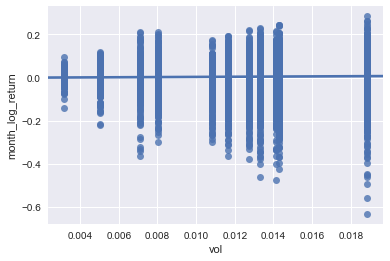

In [350]:
sns.regplot(x='vol', y='month_log_return', data=combined)

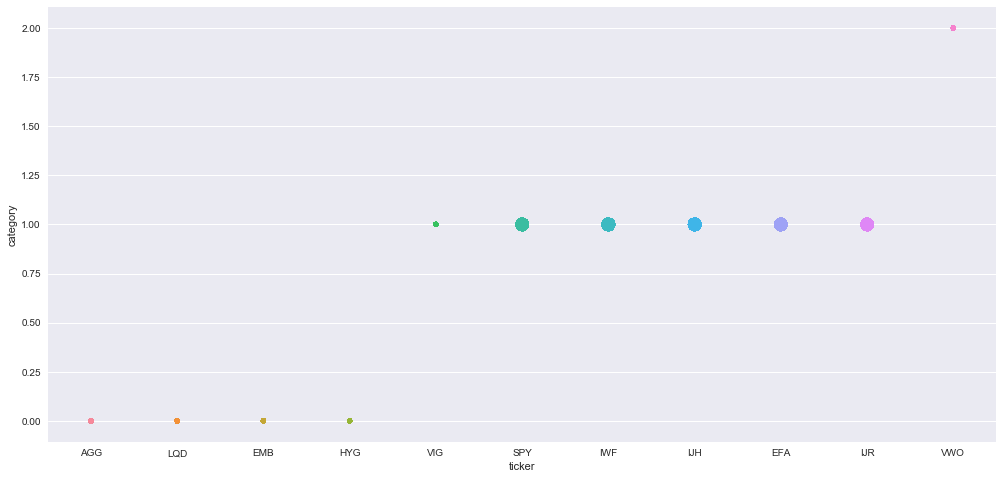

In [270]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined['vol']*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [271]:
combined = combined.dropna()

In [272]:
sec_category_map = (combined.groupby(['security_enc','category_enc']).size()
                  .reset_index()['category_enc'].values)
sec_category_map

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2])

In [359]:
n_assets = len(asset_encodings)
n_categories = len(category_encodings)
n_securities = len(security_encodings)

with pm.Model() as model:
    fast_window = 10
    slow_window = 30
    for ticker in combined['ticker'].unique():
        combined.loc[combined['ticker'] == ticker, 'fast'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()
        
        combined.loc[combined['ticker'] == ticker, 'slow'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
    combined['momentum'] = pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])
    combined = combined.dropna()
    
    a_category_mu = pm.Normal('a_category_mu', mu=0, sd=2)
    a_category_sd = pm.HalfCauchy('a_category_sd', 3)
    
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.HalfCauchy('a_security_sd', 3)
    
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    
#     b_category_mu = pm.Normal('b_category_mu', mu=0, sd=1)
#     b_category_sd = pm.HalfCauchy('b_category_sd', 2)
    
#     b_category = pm.Normal('b_category', mu=b_category_mu, sd=b_category_sd, shape=n_categories)
#     b_sec_sd = pm.HalfCauchy('b_security_sd', 2)
    
    b_nu = pm.Uniform('b_nu', 1, 20)
    b_mu = pm.Normal('b_mu', mu=0, sd=2)
    b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.StudentT('b_security', mu=b_mu, sd=b_sd, nu=b_nu, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (combined['momentum'].values * a_sec[combined['security_enc'].values] + 
             b_sec[combined['security_enc'].values])
    epsilon = pm.HalfCauchy('epsilon', beta=3)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=combined['month_log_return'].values)
    trace = pm.sample(10000, init='advi', n_init=50000, step=pm.Metropolis())

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
100%|██████████| 10000/10000 [01:39<00:00, 100.82it/s]


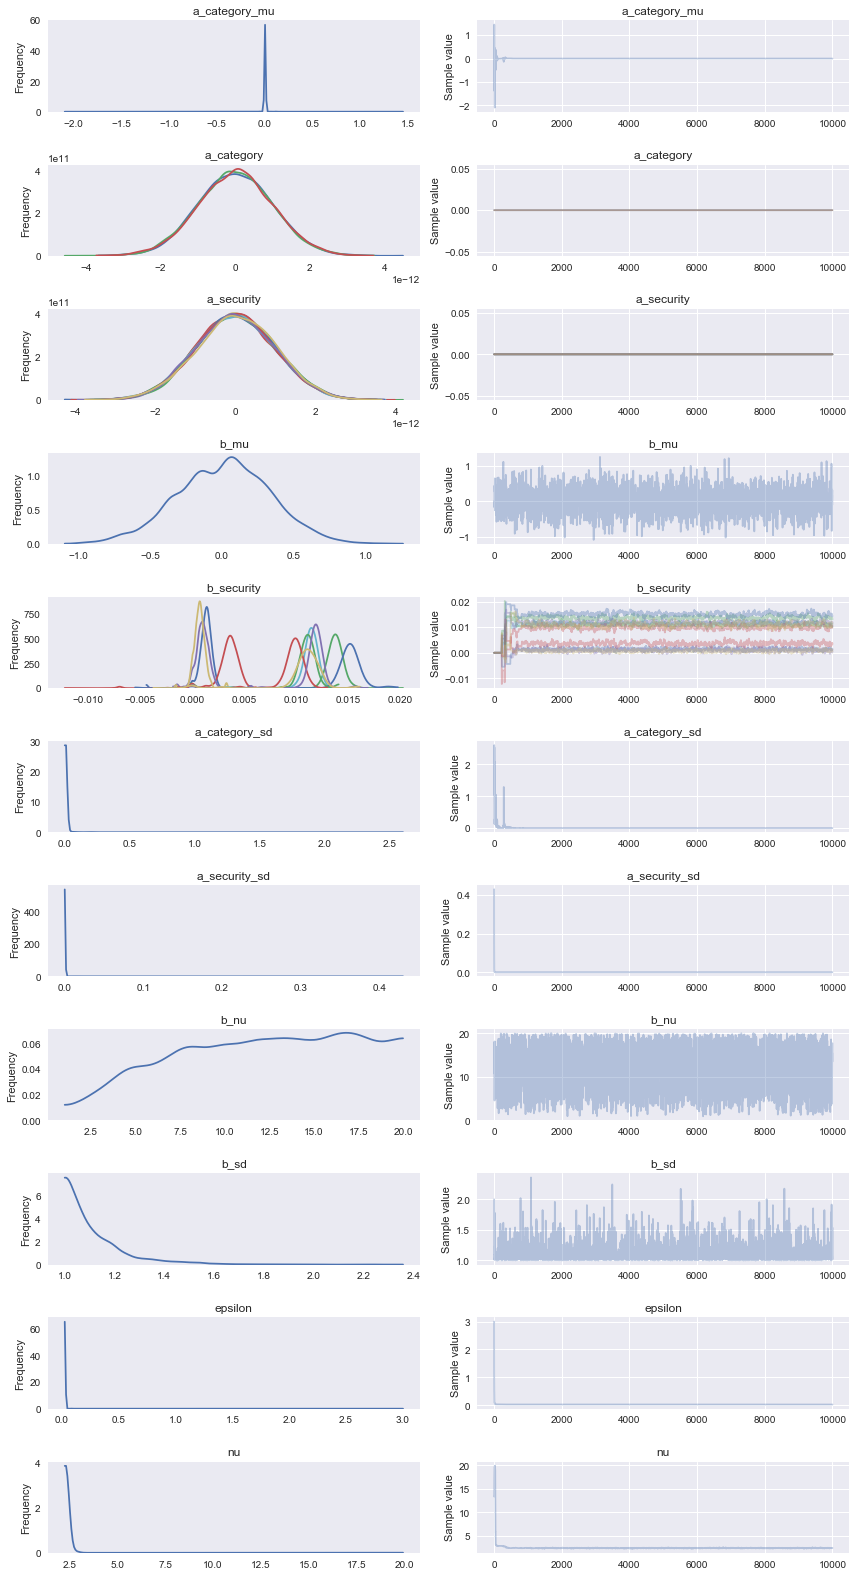

In [360]:
pm.traceplot(trace);

In [353]:
def calc_prediction_helper(row): 
    a = (row.momentum * trace['a_security'][:, row.security_enc] + trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [354]:
combined['prediction'] = combined.apply(calc_prediction_helper, axis=1)

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


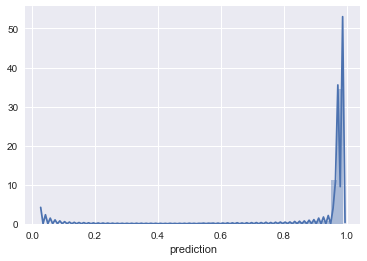

In [355]:
sns.distplot(combined['prediction'])
# sns.distplot(combined['month_log_return'])

In [356]:
len(combined.loc[combined['month_log_return'] > 0]) / len(combined)

0.5911325082549845

In [357]:
tp = len(combined.loc[(combined['month_log_return'] > 0) & (combined['prediction'] > 0)]) / len(combined[combined['prediction'] > 0])
tp

0.5911325082549845

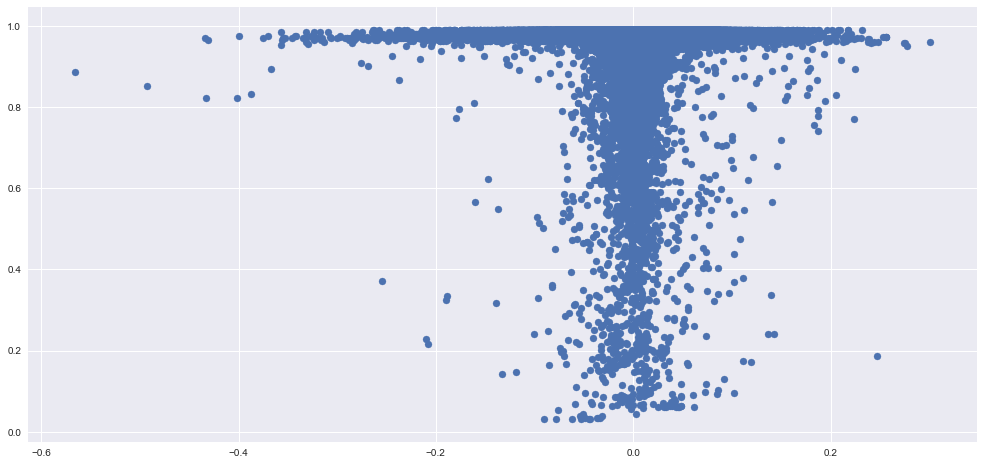

In [358]:
fig, ax = plt.subplots(figsize=(17, 8))
ax = plt.scatter(combined['month_return'], combined['prediction'])

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

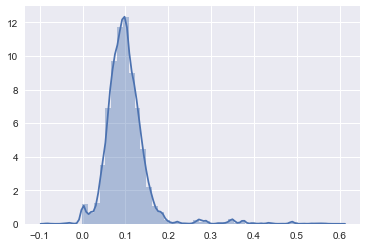

In [319]:
sns.distplot(trace['a_security'][:, 10])

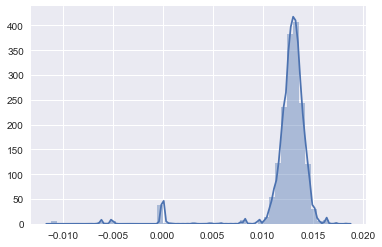

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6
